<a href="https://colab.research.google.com/github/rahulkumar1502/ERA-V2/blob/main/ERA_V2_S9_Rahul_Kumar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
sys.path.append('/content')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from model import Net
from utils import LoadDataset

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
dataloader = LoadDataset()
train,test = dataloader.getData()

100%|██████████| 170498071/170498071 [00:03<00:00, 47396272.46it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train and Test data loaded


In [ ]:
SEED = 1
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


images.shape: torch.Size([64, 3, 32, 32])
labels.shape: torch.Size([64])


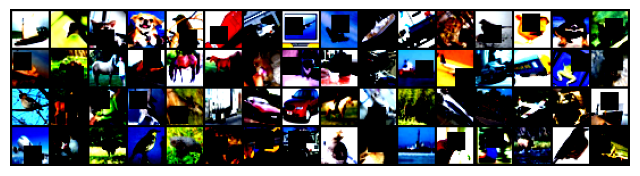

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

for images, labels in train_loader:
  print('images.shape:', images.shape)
  print('labels.shape:', labels.shape)

  plt.figure(figsize=(8,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute(1, 2, 0).clamp(0,1))
  break

In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
           Conv2d-10           [-1, 32, 30, 30]           4,608
             ReLU-11           [-1, 32, 30, 30]               0
      BatchNorm2d-12           [-1, 32, 30, 30]              64
          Dropout-13           [-1, 32, 30, 30]               0
           Conv2d-14           [-1, 32,

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
misclassified_images = []
misclassified_pred_labels = []
misclassified_true_labels = []

def train(model, device, train_loader, optimizer, epoch):

  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):

    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            try:
              misclassified_indices = ~pred.eq(target.view_as(pred)).squeeze()
              misclassified_pred_labels.extend(pred[misclassified_indices].squeeze().tolist())
              misclassified_true_labels.extend(target[misclassified_indices].tolist())
              misclassified_images.extend(data[misclassified_indices])
            except Exception as e:
              pass

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 55
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=1.7382038831710815 Batch_id=295 Accuracy=27.28:  38%|███▊      | 296/782 [09:11<14:56,  1.84s/it]